In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
random.seed(42)
np.random.seed(42)

In [4]:
num_assignments = 100  # You can adjust this number as needed
data = []

for i in range(num_assignments):
    assignment_id = i + 1
    # Teacher-defined difficulty on a scale of 1 to 5
    teacher_defined_difficulty = random.randint(1, 5)
    # Number of questions: assume between 1 and 20
    num_questions = random.randint(1, 20)
    # Average question complexity: a float between 1.0 and 5.0
    avg_question_complexity = round(random.uniform(1.0, 5.0), 2)
    # Deadline in days (e.g., between 5 and 30 days from now)
    deadline_days = random.randint(5, 30)
    
    # Synthetic formula for estimated workload hours:
    # Base effort = teacher_defined_difficulty * num_questions * avg_question_complexity
    base_effort = teacher_defined_difficulty * num_questions * avg_question_complexity
    # Add noise (±10% of the base effort)
    noise = np.random.uniform(-0.1, 0.1) * base_effort
    estimated_workload_hours = round(base_effort + noise, 2)
    
    # Derived scheduling difficulty (for later use): num_questions * avg_question_complexity
    scheduling_difficulty = round(num_questions * avg_question_complexity, 2)
    
    data.append({
        'assignment_id': assignment_id,
        'teacher_defined_difficulty': teacher_defined_difficulty,
        'num_questions': num_questions,
        'avg_question_complexity': avg_question_complexity,
        'deadline_days': deadline_days,
        'estimated_workload_hours': estimated_workload_hours,
        'scheduling_difficulty': scheduling_difficulty
    })

# Create a DataFrame from the synthetic data
df = pd.DataFrame(data)
print("First 5 records of synthetic dataset:")
print(df.head())

First 5 records of synthetic dataset:
   assignment_id  teacher_defined_difficulty  num_questions  \
0              1                           1              1   
1              2                           2              5   
2              3                           5              3   
3              4                           1              3   
4              5                           5              1   

   avg_question_complexity  deadline_days  estimated_workload_hours  \
0                     3.97             12                      3.87   
1                     3.95             26                     43.06   
2                     3.36              6                     52.74   
3                     1.87             21                      5.72   
4                     3.24             27                     15.09   

   scheduling_difficulty  
0                   3.97  
1                  19.75  
2                  10.08  
3                   5.61  
4                   3

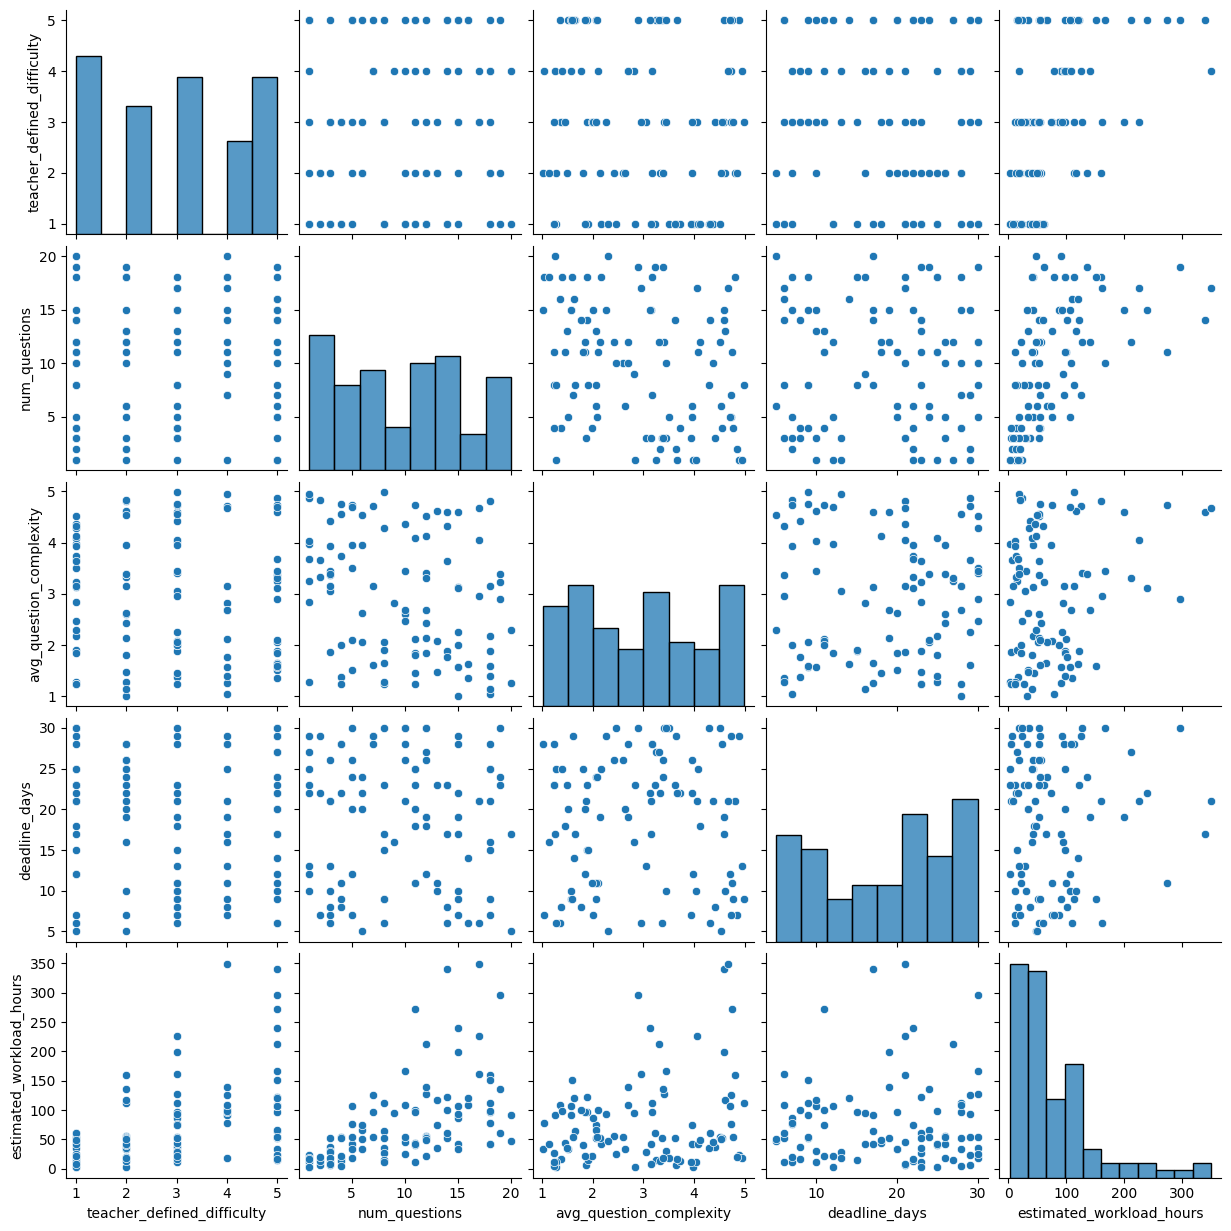

In [5]:
#####################################
# 2. Exploratory Data Analysis (EDA)
#####################################

# Pairplot to see relationships among features
sns.pairplot(df[['teacher_defined_difficulty', 'num_questions', 'avg_question_complexity', 'deadline_days', 'estimated_workload_hours']])
plt.show()

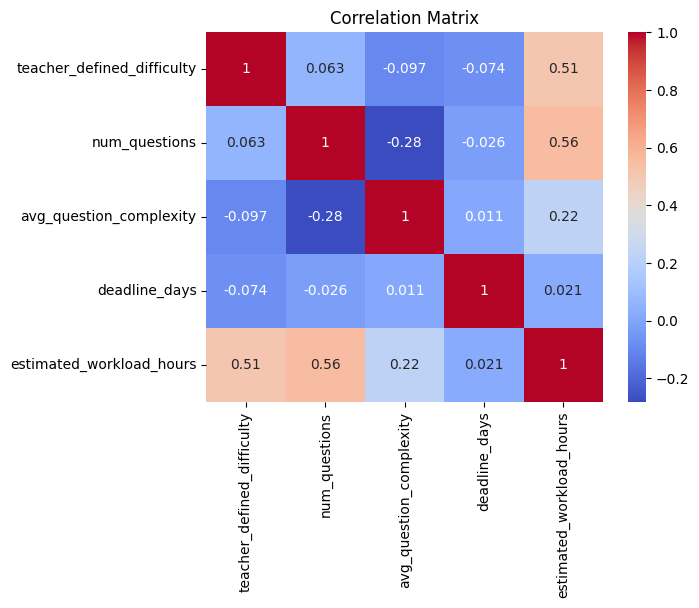

In [6]:
# Correlation matrix heatmap
corr_matrix = df[['teacher_defined_difficulty', 'num_questions', 'avg_question_complexity', 'deadline_days', 'estimated_workload_hours']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [7]:
#####################################
# 3. Building the Workload Estimation Model
#####################################

# Define the features and target variable
features = ['teacher_defined_difficulty', 'num_questions', 'avg_question_complexity', 'deadline_days']
target = 'estimated_workload_hours'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Model 1: Linear Regression ----
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Model Performance:")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"R^2 Score: {r2_lr:.2f}")

# ---- Model 2: Random Forest Regressor ----
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Model Performance:")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R^2 Score: {r2_rf:.2f}")

Linear Regression Model Performance:
Mean Squared Error (MSE): 1487.19
R^2 Score: 0.76

Random Forest Model Performance:
Mean Squared Error (MSE): 2142.15
R^2 Score: 0.66


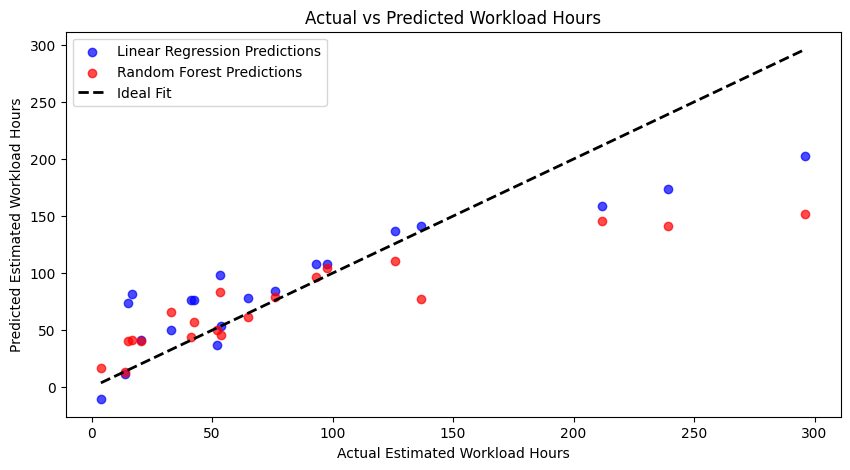

In [8]:
#####################################
# 4. Visualizing the Predictions
#####################################

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression Predictions', alpha=0.7)
plt.scatter(y_test, y_pred_rf, color='red', label='Random Forest Predictions', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Estimated Workload Hours')
plt.ylabel('Predicted Estimated Workload Hours')
plt.title('Actual vs Predicted Workload Hours')
plt.legend()
plt.show()

In [16]:
def schedule_assignments_round_robin(data, daily_work_hours=8, heavy_threshold=50, slice_size=1):
    """
    Schedules assignments using a round-robin, time-slice approach so that multiple assignments can share a day.
    
    Parameters:
        data (DataFrame): DataFrame containing assignment features, including:
            - 'assignment_id'
            - 'deadline_days' (int): deadline (in days) from now
            - 'estimated_workload_hours': predicted total hours required
            - 'scheduling_difficulty': derived metric (e.g., num_questions * avg_question_complexity)
        daily_work_hours (int): Total work hours available per day.
        heavy_threshold (float): If an assignment's scheduling_difficulty exceeds this, it's flagged as heavy.
        slice_size (float): The minimum time slice (in hours) allocated per round-robin iteration.
    
    Returns:
        schedule (dict): A mapping of day (int) to a list of scheduled tasks (dict with assignment_id, allocated hours, and heavy flag).
    """
    # Work on a copy of the data; add a column to track remaining workload hours.
    assignments = data.copy()
    assignments['remaining_hours'] = assignments['estimated_workload_hours']
    
    # Determine how many days to iterate (use the maximum deadline in the dataset)
    max_day = int(assignments['deadline_days'].max())
    schedule = {}  # key: day (int), value: list of task dicts for that day
    
    for day in range(max_day + 1):
        available_hours = daily_work_hours
        schedule[day] = []
        heavy_already_scheduled = False  # only one heavy assignment allowed per day
        
        # Get indices of assignments that still need scheduling and whose deadlines haven't passed.
        valid_indices = list(assignments[(assignments['remaining_hours'] > 0) & (assignments['deadline_days'] >= day)].index)
        
        # Sort them by deadline (sooner deadlines first) and then by remaining workload (largest first)
        valid_indices.sort(key=lambda i: (assignments.at[i, 'deadline_days'], -assignments.at[i, 'remaining_hours']))
        
        # While there is capacity on the day and valid assignments remain:
        while available_hours > 0 and valid_indices:
            # Iterate over a copy of valid_indices so that we can remove finished assignments.
            for i in valid_indices.copy():
                if available_hours <= 0:
                    break  # no capacity remains on the day
                
                # Determine if the current assignment is heavy.
                heavy = assignments.at[i, 'scheduling_difficulty'] > heavy_threshold
                # If a heavy assignment is already scheduled on this day, skip scheduling another heavy one.
                if heavy and heavy_already_scheduled:
                    continue
                
                # Allocate a small slice of time.
                allocation = min(slice_size, assignments.at[i, 'remaining_hours'], available_hours)
                if allocation <= 0:
                    continue  # nothing to allocate
                
                # Record this allocation in today's schedule.
                schedule[day].append({
                    'assignment_id': assignments.at[i, 'assignment_id'],
                    'hours': allocation,
                    'heavy': heavy
                })
                # Update the assignment's remaining hours and the day's available hours.
                assignments.at[i, 'remaining_hours'] -= allocation
                available_hours -= allocation
                
                if heavy:
                    heavy_already_scheduled = True
                
                # If this assignment is now complete, remove it from the list.
                if assignments.at[i, 'remaining_hours'] <= 0:
                    valid_indices.remove(i)
        # End of while loop for the day
    # End of day-by-day scheduling
    
    # Warn if any assignment could not be fully scheduled by its deadline.
    for idx, row in assignments.iterrows():
        if row['remaining_hours'] > 0:
            print(f"Warning: Assignment {row['assignment_id']} could not be fully scheduled before its deadline. "
                  f"Remaining hours: {row['remaining_hours']:.2f}")
    
    return schedule

# --- Example usage ---
# Make sure that 'deadline_days' is integer-typed.
df['deadline_days'] = df['deadline_days'].astype(int)

# Run the round-robin scheduler.
improved_schedule = schedule_assignments_round_robin(df, daily_work_hours=8, heavy_threshold=50, slice_size=1)

# Display the improved schedule day by day.
print("\nImproved Round-Robin Schedule (Day-wise):")
for day in sorted(improved_schedule.keys()):
    print(f"\nDay {day}:")
    for task in improved_schedule[day]:
        print(f"  Assignment {task['assignment_id']} -> Hours Allocated: {task['hours']} (Heavy: {task['heavy']})")



Improved Round-Robin Schedule (Day-wise):

Day 0:
  Assignment 100 -> Hours Allocated: 1 (Heavy: False)
  Assignment 39 -> Hours Allocated: 1 (Heavy: False)
  Assignment 89 -> Hours Allocated: 1 (Heavy: True)
  Assignment 28 -> Hours Allocated: 1 (Heavy: False)
  Assignment 3 -> Hours Allocated: 1 (Heavy: False)
  Assignment 51 -> Hours Allocated: 1 (Heavy: False)
  Assignment 60 -> Hours Allocated: 1 (Heavy: False)
  Assignment 93 -> Hours Allocated: 1 (Heavy: False)

Day 1:
  Assignment 100 -> Hours Allocated: 1 (Heavy: False)
  Assignment 39 -> Hours Allocated: 1 (Heavy: False)
  Assignment 89 -> Hours Allocated: 1 (Heavy: True)
  Assignment 28 -> Hours Allocated: 1 (Heavy: False)
  Assignment 3 -> Hours Allocated: 1 (Heavy: False)
  Assignment 51 -> Hours Allocated: 1 (Heavy: False)
  Assignment 60 -> Hours Allocated: 1 (Heavy: False)
  Assignment 93 -> Hours Allocated: 1 (Heavy: False)

Day 2:
  Assignment 100 -> Hours Allocated: 1 (Heavy: False)
  Assignment 39 -> Hours Allocate

In [17]:
import random
import numpy as np
import pandas as pd

# For reproducibility
random.seed(42)
np.random.seed(42)

# Generate realistic synthetic data: 8 assignments in a month.
num_assignments = 8
data = []

for i in range(num_assignments):
    assignment_id = i + 1
    # Teacher-defined difficulty on a scale of 1 to 5
    teacher_defined_difficulty = random.randint(1, 5)
    # Number of questions: realistic range (e.g., 1 to 10 per assignment)
    num_questions = random.randint(1, 10)
    # Average question complexity: a float between 1.0 and 5.0
    avg_question_complexity = round(random.uniform(1.0, 5.0), 2)
    # Deadline in days: assume deadlines between 7 and 30 days from now
    deadline_days = random.randint(7, 30)
    
    # Synthetic formula for estimated workload hours:
    # Base effort = teacher_defined_difficulty * num_questions * avg_question_complexity
    base_effort = teacher_defined_difficulty * num_questions * avg_question_complexity
    # Add some noise (±10% of the base effort)
    noise = np.random.uniform(-0.1, 0.1) * base_effort
    estimated_workload_hours = round(base_effort + noise, 2)
    
    # Derived scheduling difficulty: simply num_questions * avg_question_complexity
    scheduling_difficulty = round(num_questions * avg_question_complexity, 2)
    
    data.append({
        'assignment_id': assignment_id,
        'teacher_defined_difficulty': teacher_defined_difficulty,
        'num_questions': num_questions,
        'avg_question_complexity': avg_question_complexity,
        'deadline_days': deadline_days,
        'estimated_workload_hours': estimated_workload_hours,
        'scheduling_difficulty': scheduling_difficulty
    })

# Create a DataFrame with the synthetic data.
df_realistic = pd.DataFrame(data)
print("Realistic Synthetic Dataset:")
print(df_realistic)


Realistic Synthetic Dataset:
   assignment_id  teacher_defined_difficulty  num_questions  \
0              1                           1              1   
1              2                           2              3   
2              3                           5              2   
3              4                           1              2   
4              5                           5              1   
5              6                           5              7   
6              7                           3              1   
7              8                           4              6   

   avg_question_complexity  deadline_days  estimated_workload_hours  \
0                     3.97             14                      3.87   
1                     3.95             28                     25.84   
2                     3.36              8                     35.16   
3                     1.87             23                      3.81   
4                     3.24             29       

In [18]:
def schedule_assignments_round_robin(data, daily_work_hours=8, heavy_threshold=50, slice_size=1):
    """
    Schedules assignments using a round-robin, time-slice approach so that multiple assignments
    can share a day.
    
    Parameters:
        data (DataFrame): Contains assignment details:
            - 'assignment_id'
            - 'deadline_days' (int): days from now until the assignment is due
            - 'estimated_workload_hours': predicted total hours required
            - 'scheduling_difficulty': derived metric (e.g., num_questions * avg_question_complexity)
        daily_work_hours (int): Total work hours available per day.
        heavy_threshold (float): If an assignment's scheduling_difficulty exceeds this, it's flagged as heavy.
        slice_size (float): The smallest time slice (in hours) allocated per round-robin iteration.
    
    Returns:
        schedule (dict): Mapping from day (int) to a list of scheduled tasks (dict with assignment_id, allocated hours, heavy flag).
    """
    # Work on a copy of the data; add a column to track remaining hours.
    assignments = data.copy()
    assignments['remaining_hours'] = assignments['estimated_workload_hours']
    
    # Determine how many days to iterate (use the maximum deadline)
    max_day = int(assignments['deadline_days'].max())
    schedule = {}  # key: day number, value: list of scheduled tasks for that day
    
    for day in range(max_day + 1):
        available_hours = daily_work_hours
        schedule[day] = []
        heavy_already_scheduled = False  # only one heavy assignment allowed per day
        
        # Get indices of assignments that still need hours and whose deadline hasn't passed.
        valid_indices = list(assignments[(assignments['remaining_hours'] > 0) & (assignments['deadline_days'] >= day)].index)
        # Sort them by deadline (earlier deadlines first) and then by remaining hours (largest first)
        valid_indices.sort(key=lambda i: (assignments.at[i, 'deadline_days'], -assignments.at[i, 'remaining_hours']))
        
        # While there is capacity on the day and valid assignments remain:
        while available_hours > 0 and valid_indices:
            for i in valid_indices.copy():
                if available_hours <= 0:
                    break  # no capacity left on this day
                
                heavy = assignments.at[i, 'scheduling_difficulty'] > heavy_threshold
                # Skip if a heavy assignment is already scheduled and this one is heavy.
                if heavy and heavy_already_scheduled:
                    continue
                
                # Allocate a small time slice.
                allocation = min(slice_size, assignments.at[i, 'remaining_hours'], available_hours)
                if allocation <= 0:
                    continue
                
                schedule[day].append({
                    'assignment_id': assignments.at[i, 'assignment_id'],
                    'hours': allocation,
                    'heavy': heavy
                })
                
                # Update the assignment's remaining hours and the day's available hours.
                assignments.at[i, 'remaining_hours'] -= allocation
                available_hours -= allocation
                
                if heavy:
                    heavy_already_scheduled = True
                
                # If the assignment is complete, remove it from valid_indices.
                if assignments.at[i, 'remaining_hours'] <= 0:
                    valid_indices.remove(i)
                    
        # End while loop for the day
    # End day-by-day scheduling
    
    # Print a warning if any assignment could not be fully scheduled by its deadline.
    for idx, row in assignments.iterrows():
        if row['remaining_hours'] > 0:
            print(f"Warning: Assignment {row['assignment_id']} could not be fully scheduled before its deadline. "
                  f"Remaining hours: {row['remaining_hours']:.2f}")
    
    return schedule

# Ensure that the deadlines are integer values.
df_realistic['deadline_days'] = df_realistic['deadline_days'].astype(int)

# Run the round-robin scheduler.
realistic_schedule = schedule_assignments_round_robin(df_realistic, daily_work_hours=8, heavy_threshold=50, slice_size=1)

# Display the schedule day by day.
print("\nRealistic Round-Robin Schedule (Day-wise):")
for day in sorted(realistic_schedule.keys()):
    print(f"\nDay {day}:")
    for task in realistic_schedule[day]:
        print(f"  Assignment {task['assignment_id']} -> Hours Allocated: {task['hours']} (Heavy: {task['heavy']})")



Realistic Round-Robin Schedule (Day-wise):

Day 0:
  Assignment 3 -> Hours Allocated: 1 (Heavy: False)
  Assignment 7 -> Hours Allocated: 1 (Heavy: False)
  Assignment 8 -> Hours Allocated: 1 (Heavy: False)
  Assignment 1 -> Hours Allocated: 1 (Heavy: False)
  Assignment 4 -> Hours Allocated: 1 (Heavy: False)
  Assignment 6 -> Hours Allocated: 1 (Heavy: False)
  Assignment 2 -> Hours Allocated: 1 (Heavy: False)
  Assignment 5 -> Hours Allocated: 1 (Heavy: False)

Day 1:
  Assignment 3 -> Hours Allocated: 1 (Heavy: False)
  Assignment 7 -> Hours Allocated: 1 (Heavy: False)
  Assignment 8 -> Hours Allocated: 1 (Heavy: False)
  Assignment 1 -> Hours Allocated: 1 (Heavy: False)
  Assignment 4 -> Hours Allocated: 1 (Heavy: False)
  Assignment 6 -> Hours Allocated: 1 (Heavy: False)
  Assignment 2 -> Hours Allocated: 1 (Heavy: False)
  Assignment 5 -> Hours Allocated: 1 (Heavy: False)

Day 2:
  Assignment 3 -> Hours Allocated: 1 (Heavy: False)
  Assignment 7 -> Hours Allocated: 1 (Heavy: Fal